**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
October 30, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

# **Assignment 1: “Word Embeddings and Probabilistic Language Models”**
**Due**: Monday, November 13, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: F.R.I.E.N.D.S and  Word2Vec (Grade (2 + 2 + 4) = 8)**

[Friends](https://en.wikipedia.org/wiki/Friends) is an American television sitcom, created by David Crane and Marta Kauffman. In this assignment we will use the transcripts from the show to train a Word2Vec model using the [Gensim](https://radimrehurek.com/gensim/) library.

### Subtask 1: Pre-processing
We start by loading and cleaning the data. Download the dataset for this assignment and load the `friends_quotes.csv` using pandas. The dataset is from Kaggle (https://www.kaggle.com/ryanstonebraker/friends-transcript) and is created for building a classifier that  determines which friend from the Friend's TV Show would be most likely to say a quote. The column `quote` contains a line from the movie and the `author` is the one who said it. Since these are the only two columns we need, we remove the rest and only keep these two columns.

In [1]:
import re
import pandas as pd
from collections import defaultdict
import spacy
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
df =  pd.read_csv("friends_quotes.csv")
df.drop(['episode_number','episode_title', 'quote_order','season'], inplace=True, axis=1)
df.head(10)

,author,quote
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hum..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."
5,Monica,"Okay, everybody relax. This is not even a date..."
6,Chandler,Sounds like a date to me.
7,Chandler,"Alright, so I'm back in high school, I'm stand..."
8,All,"Oh, yeah. Had that dream."
9,Chandler,"Then I look down, and I realize there's a phon..."


Fortunately, there is no missing data, so we do not need to worry about that.

In [3]:
df.isnull().sum() # check for missing data

author    0
quote     0
dtype: int64

Use SpaCy to preprocess the text. For this, perform the following steps:
- lowercase the words
- remove the stopwords and single characters
- use regex to remove non-alphabetic characters (anything that is not a number or alphabet including punctuations), in other words only keep "a" to "z" and digits.
- remove lines that have less than 4 words, since they cannot contribute much to the training process.

Please do not add any additional steps on your own or additional cleaning as we want to achieve comparable results.

In [4]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def cleaning(text):
    doc= nlp(text)
    #remove stopwords or single character and lines that have less than 3 words
    cleaned_text = " ".join(str(token) for token in doc if str(token) not in stopwords and len(doc)>3 and  len(token)>1)
    return cleaned_text

#df["quote"] = # lowercase and remove non-alphabetic characters
df["quote"] = df["quote"].str.lower().replace('[^a-zA-Z]', ' ', regex=True)
df["quote"] = df["quote"].apply(lambda x : cleaning(x))

quotes =[] # to save all the lines
quotes= list(filter(None,df["quote"]))



/home/kushal/.config/python.env/nlptrans.env/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


The next step is to build the vocabulary of the words and word combinations we want to learn representations from. We choose a subset of the most frequent words and bigrams to represent our corpus.
- Use the Gensim Phrases package to automatically detect common phrases (bigrams) from a list of lines from the previous step (`min_count=10`). Now words like New_York will be considered as one entity and character names like joey_tribbiani will be recognized.
- Create a list of words/bigrams with their frequencies and choose the top 15.000 words for the vocabulary, in order to keep the computation time-limited and to choose the most important words.

In [5]:
from gensim.models.phrases import Phrases
words = [line.split(' ') for line in quotes] #list of all words#
phrases = Phrases(words, min_count=10)#define the phraser for bi-gram creation#
new_lines = phrases[words] #transform the lines#


INFO - 05:01:25: collecting all words and their counts
INFO - 05:01:25: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 05:01:25: PROGRESS: at sentence #10000, processed 73384 words and 44183 word types
INFO - 05:01:25: PROGRESS: at sentence #20000, processed 146896 words and 77278 word types
INFO - 05:01:25: PROGRESS: at sentence #30000, processed 223085 words and 106430 word types
INFO - 05:01:25: PROGRESS: at sentence #40000, processed 297030 words and 133475 word types
INFO - 05:01:25: collected 157120 token types (unigram + bigrams) from a corpus of 364939 words and 48537 sentences
INFO - 05:01:25: merged Phrases<157120 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 05:01:25: Phrases lifecycle event {'msg': 'built Phrases<157120 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 0.25s', 'datetime': '2023-11-13T05:01:25.973620', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep  2 2023, 14:16:33) [GCC 13.2.1 20230801]', 'platfor

In [6]:
### find the top words for the vocabulary###
vocab=sorted(phrases.vocab.items(), key = lambda x: x[1], reverse=True)[:15000]###top words ###

In [7]:
word_freq = dict(vocab)

word_freq['central_perk']

36

In [8]:
word_freq['joey']

2342

### Subtask 2: Training the Model


Use the Gensim implementation of Word2Vec to train a model on the scripts. The training can be divided into 3 stages:


1) Set up your model with parameters; define your parameters in such a way that the following conditions are satisfied:
 - ignore all words that have a total frequency of less than 2.
 - dimensions of the embeddings: 100
 - initial learning rate (step size) of 0.03
 - 20 negative samples
 - window size 3
 - the learning rate in the training will decrease as you apply more and more updates. Most of the time when starting with gradient descent the initial steps can be larger, and as we get close to the local minima it is best to use smaller steps to avoid jumping over the local minima. This adjustment is done internally using a learning rate scheduler. Make sure that the smallest learning rate does not go below 0.0001.
 - set the threshold for configuring which higher-frequency words are randomly down-sampled to 6e-5. This parameter forces the sampling to choose the very frequent words less often in the sampling.
 - set the hashfunction of the word2vec to the given function.
 - train on a single worker to make sure you get the same result as ours.

In [9]:
from gensim.models import Word2Vec
def hash(astring):
    return ord(astring[0])

In [10]:
 ### your code ###
w2v = Word2Vec(
    new_lines,
    workers = 1,
    vector_size = 100,
    min_count = 2,
    window = 3,
    sample = 6e-5,
    negative= 20,
    alpha = 0.03,
    min_alpha = 0.0001,
    hashfxn= hash,

)

INFO - 05:01:26: collecting all words and their counts
INFO - 05:01:26: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 05:01:26: PROGRESS: at sentence #10000, processed 57478 words, keeping 7546 word types
INFO - 05:01:26: PROGRESS: at sentence #20000, processed 115638 words, keeping 10398 word types
INFO - 05:01:26: PROGRESS: at sentence #30000, processed 174962 words, keeping 12346 word types
INFO - 05:01:26: PROGRESS: at sentence #40000, processed 233279 words, keeping 14069 word types
INFO - 05:01:26: collected 15818 word types from a corpus of 282772 raw words and 48537 sentences
INFO - 05:01:26: Creating a fresh vocabulary
INFO - 05:01:26: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 9351 unique words (59.12% of original 15818, drops 6467)', 'datetime': '2023-11-13T05:01:26.456505', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep  2 2023, 14:16:33) [GCC 13.2.1 20230801]', 'platform': 'Linux-6.6.1-arch1-1-x86_64-with-glibc2.38', 'event'

2) Before training, Word2Vec requires us to build the vocabulary table by filtering out the unique words and doing some basic counts on them.
Use the `build_vocab` function to process the data. If you look at the logs you can see the effect of `min_count` and `sample` on the word corpus.

In [11]:
w2v.build_vocab(new_lines) ### your code ###

INFO - 05:01:28: collecting all words and their counts
INFO - 05:01:28: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 05:01:28: PROGRESS: at sentence #10000, processed 57478 words, keeping 7546 word types
INFO - 05:01:28: PROGRESS: at sentence #20000, processed 115638 words, keeping 10398 word types
INFO - 05:01:29: PROGRESS: at sentence #30000, processed 174962 words, keeping 12346 word types
INFO - 05:01:29: PROGRESS: at sentence #40000, processed 233279 words, keeping 14069 word types
INFO - 05:01:29: collected 15818 word types from a corpus of 282772 raw words and 48537 sentences
INFO - 05:01:29: Creating a fresh vocabulary
INFO - 05:01:29: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 9351 unique words (59.12% of original 15818, drops 6467)', 'datetime': '2023-11-13T05:01:29.179360', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep  2 2023, 14:16:33) [GCC 13.2.1 20230801]', 'platform': 'Linux-6.6.1-arch1-1-x86_64-with-glibc2.38', 'event'

3) Finally, we  train the model. Train the model for 100 epochs. This will take a while. As we do not plan to train the model any further, we call `init_sims()`, which will make the model much more memory-efficient by precomputing L2-norms of word weight vectors for further analysis.

In [12]:
w2v.train(new_lines,total_words= len(new_lines),epochs=100) ### your code ###

WARNING - 05:01:29: Effective 'alpha' higher than previous training cycles
INFO - 05:01:29: Word2Vec lifecycle event {'msg': 'training model with 1 workers on 9351 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3 shrink_windows=True', 'datetime': '2023-11-13T05:01:29.259839', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep  2 2023, 14:16:33) [GCC 13.2.1 20230801]', 'platform': 'Linux-6.6.1-arch1-1-x86_64-with-glibc2.38', 'event': 'train'}
INFO - 05:01:29: EPOCH 0: training on 282772 raw words (126698 effective words) took 0.5s, 269448 effective words/s
WARNING - 05:01:29: EPOCH 0: supplied raw word count (282772) did not equal expected count (48537)
INFO - 05:01:30: EPOCH 1: training on 282772 raw words (126509 effective words) took 0.5s, 254422 effective words/s
WARNING - 05:01:30: EPOCH 1: supplied raw word count (282772) did not equal expected count (48537)
INFO - 05:01:30: EPOCH 2: training on 282772 raw words (126687 effective words) took 0.5s, 272021

(12661051, 28277200)

In [13]:
w2v.init_sims(replace=True)

/tmp/ipykernel_170119/2512947105.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v.init_sims(replace=True)
WARNING - 05:02:15: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


### Subtask 3: Exploring the Model


As mentioned in the lecture, word embeddings are suited for similarity and analogy tasks. Let's explore some of that with our dataset:

We look for the most similar words to the name of the famous coffee shop where most of the episodes took place, namely `central_perk` and also one of the characters `joey`. If you have followed the exercise correctly until now, you should see that words like `laying` are similar to `central_perk` and the other main characters are also considered similar to `joey`.



In [14]:
w2v.wv.most_similar(positive=['central_perk'])

[('conan', 0.5344635248184204),
 ('laying', 0.5073391199111938),
 ('hippity', 0.48014700412750244),
 ('recliner', 0.4704996347427368),
 ('scene', 0.4687216877937317),
 ('sitting_couch', 0.4459496736526489),
 ('mitzi', 0.43868589401245117),
 ('josephine', 0.4304845631122589),
 ('crossword', 0.42009297013282776),
 ('enters', 0.40591785311698914)]

In [15]:
###your code###
w2v.wv.most_similar('joey')

[('chandler', 0.79517662525177),
 ('ross', 0.6759696006774902),
 ('rachel', 0.6685718297958374),
 ('phoebe', 0.6330486536026001),
 ('monica', 0.6143048405647278),
 ('right', 0.5854146480560303),
 ('hey', 0.580683708190918),
 ('look', 0.5397475361824036),
 ('apartment', 0.5388873219490051),
 ('okay', 0.5228437185287476)]

Look at the similarity of `green` to `rachel` (her lastname) and `ross`  and `spaceship` (urelated). The first one should have a high and the second a low score. Finally, look at the similarity of `smelly_cat` ( a song from pheobe) and `song` the similarity should be high.

In [16]:
###your code###
w2v.wv.similarity("green","rachel")

0.09799353

In [17]:
###your code###
w2v.wv.similarity("ross","spaceship")

-0.15830864

In [18]:
###your code###
w2v.wv.similarity("smelly_cat","song")

0.48799065

We can also ask our model to give us the word that does not belong to a list of words. Let's see from the list of all 5 characters which one is the most dissimilar?


In [19]:
character_names= ['joey', 'rachel', 'phoebe','monica','chandler']

In [20]:
w2v.wv.doesnt_match(character_names)### your code###

'joey'

Based on the analogies, which word is to `monica` as `man` is to `women`? (print the top 3 words); you should get `chandler`among the answers.

In [21]:
w2v.wv.most_similar(positive=['monica','woman'],negative=['man'])### your code###

[('rachel', 0.5429796576499939),
 ('chandler', 0.4787571132183075),
 ('phoebe', 0.4751168489456177),
 ('mrs_green', 0.43189340829849243),
 ('ross', 0.4094097912311554),
 ('left', 0.37180882692337036),
 ('room', 0.3692134916782379),
 ('phone', 0.36619970202445984),
 ('said', 0.36208784580230713),
 ('oh_god', 0.35728925466537476)]

Finally, lets use [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) to look at the distribution of our embeddings in the vector space for the character `joey`. Follow the instructions and fill in the blank in the `tsneplot` function.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from sklearn.manifold import TSNE

In [23]:
def tsneplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction for the top 10 most similar and dissimilar words
    """
    embs = np.empty((0, 100), dtype='f')# to save all the embeddings
    word_labels = [word]
    color_list  = ['green']

    # adds the vector of the query word
    embs = np.append(embs, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    all_sims = model.wv.most_similar([word], topn=sys.maxsize)
    far_words = list(reversed(all_sims[-10:]))

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        embs = np.append(embs, wrd_vector, axis=0)

    # adds the vector for each of the furthest words to the array
    for wrd_score in far_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('red')
        embs = np.append(embs, wrd_vector, axis=0)

    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=110, perplexity=15).fit_transform(embs)

    # sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)

    # basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+10)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+10)

    plt.title('t-SNE visualization for {}'.format(word.title()))


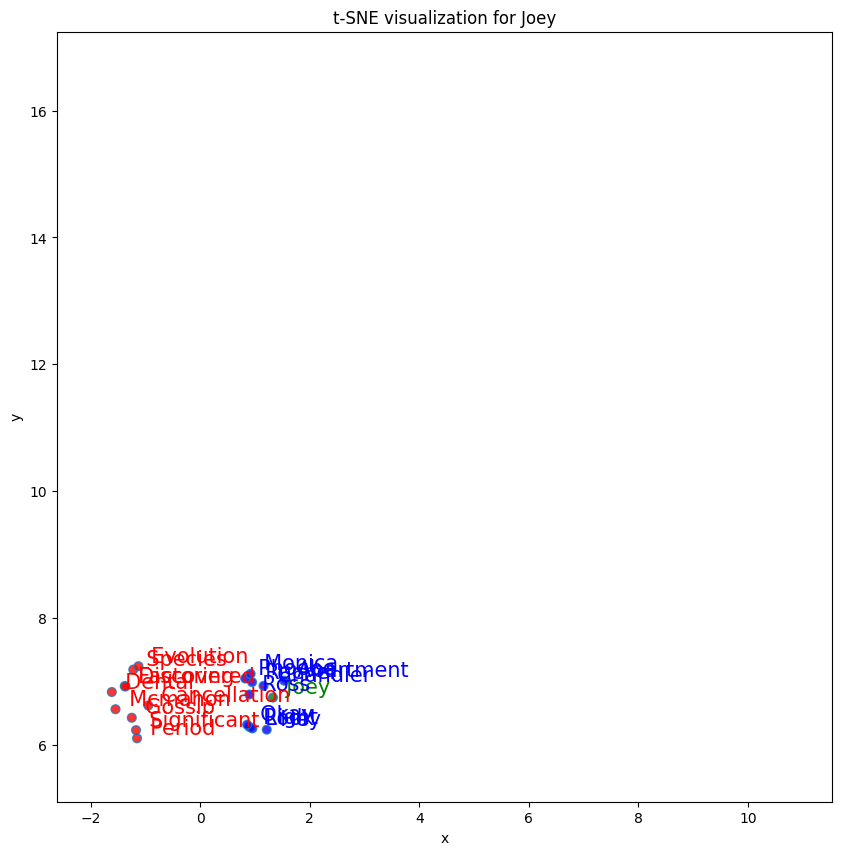

In [24]:
tsneplot(w2v, 'joey')

## **Task 2: Questions on the Conceptual Level (non-programming) (Grade (2 + 1 + 1 + 4) = 8)**

Please answer the following questions in the notebook cells using markdown. Be precise and short.

### Subtask 1: For gradient descent, what advantage has a decaying learning rate?

<<< your answer >>>

### Subtask 2: Why is it easier to maximize the log likelihood instead of the "normal" likelihood?

<<< your answer >>>

### Subtask 3: Name one advantage that fastText has over Word2Vec?

<<< your answer >>>

### Subtask 4: Compute the partial derivate of softmax loss for word2vec with

---

respect to the center word vector.
$$ \frac{\partial J}{\partial v_c} =\frac{\partial}{\partial v_c}\left[ -log \left( \frac{exp(u^T_o v_c)}{\Sigma_{w \in Vocab} exp(u^T_o v_c)} \right)\right] $$
use $U$ to denote the matrix of all embeddings and $y$ for a one-hot vector with a 1 for the true outside word $o$, and $\hat{y}$ for the predicted distribution $P(w|c)$.

<<< your answer >>>

## **Task 3: Auto-Complete Feature (Grade (2 + 6 + 4) = 12)**

Let's get even more practical! In this problem set, you will build your own auto-completion system that you see every day while using search engines.

[google]: https://www.thedad.com/wp-content/uploads/2018/05/screen-shot-2018-05-12-at-2-01-56-pm.png "google auto complete"

![google]
By the end of this assignment, you will develop a simple prototype of such a system using n-gram language model. At the heart of the system is a language model that assigns the probability to a sequence of words. We take advantage of this probability calculation to predict the next word.

The problem set contains 3 main parts:

1. Load and preprocess data (tokenize and split into train and test)
2. Develop n-gram based language model by estimating the conditional probability of the next word.
3. Evaluate the model by computing the perplexity score.


### Subtask 1: Load and Preprocess Data
We use a subset of English tweets to train our model. Run the cell below to load the data and observe a few lines of it. Notice that tweets are saved in a text file, where the individual tweets are separated by `\n`

In [25]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])


with open("./twitter.txt", "r") as f:
    data = f.readlines() #changed the code from read to readlines to make data a list of lines
print("First 500 characters of the data:")
display(data[0:500])
print("-------")

First 500 characters of the data:


['How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\n',
 "When you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\n",
 "they've decided its more fun if I don't.\n",
 'So Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)\n',
 'Words from a complete stranger! Made my birthday even better :)\n',
 'First Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!\n',
 'i no! i get another day off from skool due to the wonderful snow (: and THIS wakes me up...damn thing\n',
 "I'm coo... Jus at work hella tired r u ever in cali\n",
 'The new sundrop commercial ...hehe love at first sight\n',
 'we need to reconnect THIS WEEK\n',
 'I always wonder how the guys on the auctions shows learned to talk so fast!? all I hear is djsosnekspqnslanskam.\n',
 'Dammnnnnn what a catch\n',
 'such a great picture! The green shirt totally brings out you

-------


Now we need to separate the tweets and split them into train and test set. Apply the following pre-processing steps:

1. Split data into sentences using "\n" as the delimiter and remove the leading and trailing spaces (drop empty sentences)
2. Tokenize the sentences into words using SpaCy and lowercase them. (notice that we do not remove stop words or punctuations.)
3. Divide the sentences into 80 percent training and 20 percent test set. No validation set is required. Although in a real-world application it is best to set aside part of the data for hyperparameter tuning.
4. To limit the vocabulary and remove potential spelling mistakes, make a vocabulary of the words that appear at least 2 times. The rest of the words will be replaced by the `<unk>` symbol. This is a crucial step since if your model encounters a word that it never saw during training, it won't have an input word that helps determining the next word for suggestion. We use the `<unk>` word for **out of Vocabulary (OOV)** words. Keep in mind that we built the vocabulary on the training data only.

In [26]:
sentences = [datas.strip() for datas in data if datas.strip() ]#split
#remove spaces and drop empty sentences

In [27]:
tokenized_corpus = []# list of list of the tokens in a sentence
##Your Code###
for sentence in sentences:
    doc = nlp(sentence)
    tokensied_sentence = [token.text.lower() for token in doc]
    tokenized_corpus.append(tokensied_sentence)

/home/kushal/.config/python.env/nlptrans.env/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [28]:
from random import Random
Random(4).shuffle(tokenized_corpus)

split_ratio = 0.8
total_sentence = len(tokenized_corpus)
split_idx = int(split_ratio*total_sentence)
train = tokenized_corpus[:split_idx]##Your Code###
test = tokenized_corpus[split_idx:]##Your Code###

In [29]:
from collections import Counter
flatten_corpus = [word for sentence in train for word in sentence]### Flatten the train corpus ###
word_counts = Counter(flatten_corpus)### count the number of each token ###
vocab = [word for word,count in word_counts.items() if count>=2]

### keep only the ones with frequency bigger than 2 ###
print(len(vocab)) ### should be 14861 ###
train_replaced = []
test_replaced = []
for sentence in train:
    ### adjust the sentence to contain the word in the vocabulary and <unk> for the rest ####
    sentence_replaced = [word if word in vocab else "<unk>" for word in sentence]
    train_replaced.append(sentence_replaced)

for sentence in test:
    sentence_replaced = [word if word in vocab else "<unk>" for word in sentence]
    test_replaced.append(sentence_replaced)

14861


### Subtask 2: N-gram Based Language Model:
In this section, you will develop an n-grams language model [**1. Large Language Models (LLMs), slide 1-24**]. We assume that the probability of the next word depends only on the previous n-gram or previous n words. We compute this probability by counting the occurrences in the corpus.
The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-1}, w_{t-2} \cdots w_{t-n}$ can be estimated as follows:

$$ \hat{P}(w_t | w_{t-1}\dots w_{t-n}) = \frac{C(w_{t-1}\dots w_{t-n}, w_t)}{C(w_{t-1}\dots w_{t-n})}  $$

The numerator is the number of times word '$w_t$' appears after the n-gram, and the denominator is the number of times the n-gram occurs in the corpus, where $C(\cdots)$ is a count function. Later, we add k-smoothing to avoid errors when any counts are zero.

To tackle the problem of probability estimation we divide the problem into 3 parts. In the following you will:
1. Implement a function that computes the counts of n-grams for an arbitrary number n.
2. Estimate the probability of a word given the prior n-words using the n-gram counts.
3. Calculate probabilities for all possible words.
The steps are detailed below.

Let's start by implementing a function that computes the counts of n-grams for an arbitrary number n.
- Prepend necessary starting markers `<s>` to indicate the beginning of the sentence. In the case of a bi-gram model, you need to prepend two start tokens `<s><s>` to be able to predict the first word. "hello world"-> "`<s><s>`hello world".
- Append an end token `<e>` so that the model can predict when to finish a sentence.
- Create a dictionary to store all the n_gram counts.

In [30]:
def n_grams_counts(corpus, n):
    """
    Count all n-grams in the corpus given the parameter n

    data: List of lists of words (your tokenized corpus)
    n: n in the n-gram

    Returns: A dictionary that maps a tuple of n words to its frequency
    """
    start_token='<s>'
    end_token = '<e>'
    n_grams = defaultdict(int)
    for sentence in corpus:

        if n==1:
            sentence = [start_token] + sentence + [end_token] ### add start and end token ###
        else:
            sentence = [start_token]*(n-1) + sentence + [end_token]
        # convert list to tuple so it can be used a the key in the dictionary
        for i in range(len(sentence) - n + 1):
            n_gram = tuple(sentence[i:i + n])
            n_grams[n_gram] += 1


        ###iterate over the n-grams in the sentence, you can use the range() function, and increament the counts in the
        ## n_grams dictionary, where the key is the n_gram and the value is count
    return n_grams

The next step is to estimate the probability of a word given the prior n words using the n-gram counts, based on the formula given at the beginning of this task. To deal with the problem of zero division we add k-smoothing. K-smoothing adds a positive constant $k$ to each numerator and $k \times |vocabulary size|$ in the denominator. Below we will define a function that takes in a dictionary `n_gram_cnt`, where the key is the n-gram, and the value is the count of that n-gram, plus a dictionary for `plus_current_gram_cnt`, which you'll use to find the count for the previous n-gram plus the current word. Notice that these dictionaries are computed using the previous function `n_grams_counts`.


In [31]:
def probability(word, prev_n_gram,
                         n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Estimate the probabilities of the next word using the n-gram counts with k-smoothing
    word: next word
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of words in the vocabulary

    Returns: A probability
    """

    prev_n_gram = tuple(prev_n_gram)

    prev_n_gram_cnt =  n_gram_cnts.get(prev_n_gram,0)# get the previous n-gram count from the dictionary
    denominator = prev_n_gram_cnt + (k * vocab_size) # denominator with the previous n-gram count and k-smoothing
    plus_current_gram =  prev_n_gram + (word,)# add the current word to the n-gram
    plus_current_gram_cnts = plus_current_gram_cnts.get(plus_current_gram, 0) # get the current n-gram count using the dictionary
    numerator = plus_current_gram_cnts + k #calculate the numerator with k-smoothing
    prob = numerator/denominator

    return prob

Let's use the functions we have defined to calculate probabilities for all possible words.


In [32]:
def probabilities(prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab):
    """
    Estimate the probabilities for all the words in the vocabulary given the previous n-gram
    prev_n_gram: previous n-gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cntsplus_current_gram_cnt: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words

    Returns: A dictionary mapping from next words to the probability.
    """
    prev_n_gram = tuple(prev_n_gram)

    vocab.extend(['<e>', '<unk>']) # add <e> <unk> to the vocabulary
    vocabulary_size = len(vocab)#compute the size

    probabilities = {}
    for word in vocab:
        ### compute the probability
        prob = probability(word, prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocabulary_size)
        probabilities[word] = prob
    return probabilities

In [33]:
# Predict the probability of all possible words after the unigram "the"
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
unique_words = list(set(sentences[0] + sentences[1] + sentences[2]+ sentences[3]))
unigram_counts = n_grams_counts(sentences, 1)
bigram_counts = n_grams_counts(sentences, 2)
print("The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.")
probabilities(["the"], unigram_counts, bigram_counts, unique_words)

The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.


{'shining': 0.05263157894736842,
 'plants': 0.05263157894736842,
 'mars': 0.05263157894736842,
 'moon': 0.21052631578947367,
 'a': 0.05263157894736842,
 'tonight': 0.05263157894736842,
 'plant': 0.05263157894736842,
 'are': 0.05263157894736842,
 'is': 0.05263157894736842,
 'shinnig': 0.05263157894736842,
 'stars': 0.05263157894736842,
 'and': 0.05263157894736842,
 'bright': 0.05263157894736842,
 'the': 0.05263157894736842,
 '<e>': 0.05263157894736842,
 '<unk>': 0.05263157894736842}

### Subtask 3: Evaluation

In this part, we use the perplexity score to evaluate your model on the test set. The perplexity score of the test set on an n-gram model is defined as follows:

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } $$
- where $N$ is the length of the sentence. ($N-1$ is used because in the code we start from the index 0).
- $n$ is the number of words in the n-gram.
- $W$ is the n-gram

Notice that we have already computed this probability.

The higher the probabilities are, the lower the perplexity will be.

In [34]:
def perplexity(sentence, n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Calculate perplexity for a list of sentences
    sentence: List of strings
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of unique words in the vocabulary
    k: positive smoothing constant

    Returns: Perplexity score for a single sentence
    """

    n =  len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts

    sentence = ['<s>'] + sentence + ['<e>'] # prepend <s> and append <e>
    sentence = tuple(sentence)
    N = len(sentence)# length of sentence


    product_pi = 1.0

    ### Compute the product of probabilities ###

    for t in range(n, N):
        n_gram = sentence[t - n:t] # get the n-gram before the predicted word (n-gram before t )
        word = sentence[t]  # get the word to be predicted (position t)
        prob = probability(word, n_gram, n_gram_cnts, plus_current_gram_cnts, vocab_size, k)

        product_pi *= prob  # Update the product of the probabilities

    perplexity = product_pi ** (1 / float(N))  # Take the Nth root of the product
    return perplexity

Use `perplexity` function to find the perplexity of a bi-gram model on the first training sample and on the first test sample (first element of the set).

In [35]:
bigram_counts = n_grams_counts(tokenized_corpus,2)### your code ###
trigram_counts = n_grams_counts(tokenized_corpus,3)### your code ###

perplexity_train = perplexity(train_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

perplexity_test = perplexity(test_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for test sample: {perplexity_test:.4f}")# the perplexity for the train sample should be much lower

Perplexity for first train sample: 0.0107
Perplexity for test sample: 0.0005


Finally, let's use the model we created to generate an auto-complete system that makes suggestions.

In [36]:
def suggest_a_word(up_to_here, n_gram_cnts, plus_current_gram_cnts, vocab , start_with=None):
    """
    Get suggestion for the next word
    up_to_here: the sentence so far, must have length > n
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    start_with: If not None, specifies the first few letters of the next word

    Returns: (most likely next word,  probability)
    """
    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts
    previous_n_gram = up_to_here[-n:] # get the last 'n' words as the previous n-gram from the input sentence

    if start_with is not None:
        filter_vocab = [word for word in vocab if word.startswith(start_with)]
    else:
        filter_vocab = vocab
    best_word = None
    best_prob = 0.0
    probabs =  probabilities(previous_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab)    #stimate the probabilities for each word in the vocabulary

    ### sort the probability for higher to lower and return the highest probability word,probability tuple
    #if start_with is specified then return the highest probability word that starts with that specific character

    for word in filter_vocab:
        probability = probabs.get(word, 0.0)
        if probability > best_prob:
            best_word = word
            best_prob = probability

    return (best_word, best_prob)


Test your model based on the bi-gram model created on the training corpus.

In [37]:
previous_tokens=['i','like']
start_with='b'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('better', 0.00013286388095396266)

In [38]:
previous_tokens=['i','like','to']
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('see', 0.0010005336179295624)

In [39]:
previous_tokens=["hello", "my", "name", "is"]
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('"', 0.000201450443190975)

In [40]:
previous_tokens=["hello", "my", "name", "is"]
start_with='a'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('allison', 0.00013430029546065002)

## **Task 4: Understanding GloVe (Grade (2 + 4.25 + 4 + 1.75) = 12)**

In this part, you will implement the [GloVe](https://nlp.stanford.edu/projects/glove/) model and train your own word vectors with gradient
descent and numpy. GloVe stands for Global Vectors for word representation, which was developed by researchers at Stanford University to generate word embeddings from corpus statistics.
The statistics of the corpus are represented by a co-occurrence matrix, indicating how often a particular word pair occurs together.
GloVe is based on ratios of probabilities from this co-occurrence matrix, combining the intuitions of count-based models while also being similar to neural models like word2vec.
From this matrix, one can compute the co-occurrence probabilities. We motivate this with an example:

$P_{ik} = P(i,j)$ -> co-occurrence probability or joint probability of words $i$ and $k$

$P_{jk}$ ->co-occurrence probability of words $j$ and $k$

$\frac{P_{ik}}{P_{jk}}$-> corelation between $i$ and $j$ with the prob word $k$

This ratio gives us some insight into the co-relation of the probe word $k$ with the words $i$ and $j$.
An example is shown below for different prob words $k$, where $i$ and $j$ are `ice` and `steam`, respectively.


![glove](https://nlp.stanford.edu/projects/glove/images/table.png)


Image taken from Stanford NLP.

Compared to the raw probabilities, the ratio of probabilities is better able to distinguish relevant words from irrelevant words. Consider the raw probabilities (the first two rows), the values are close to one another and not indicative of the relationships. However, the ratios have more distinct values.

This ratio can be small, large, or equal to 1 depending on the prob word and their co-relation. In the example above, the ratio between ice and steam for `k=solid` is large and for `k=gas` is small, indicating that `solid` is related to ice but `gas` is irrelevant. On the other hand, `water` is not a discriminating element between them, and therefore the ratio is close to one. The same applies to an irrelevant word like `fashion`.

The GloVe model is built on the idea that the "ratio of conditional probabilities represents the word meanings" and a neural model is trained to estimate this conditional probability.

$F(w_i,w_j,\tilde{w_k})=\frac{P_ik}{P_jk}$ -> the right-hand side is computed from the corpus statistics, $w$ is the word vector and $\tilde{w_k}$ is the context vector

The GloVe model embeds the words in a vector space and claims that the difference between them (distinguishing factor) is hidden in the ratio of probabilities. In vector space, the best way to encode this is by vector differences.

$F((w_i-w_j),\tilde{w_k})=\frac{P_ik}{P_jk}$

At this point, the left-hand side is a vector and the right-hand side is a scalar showing the similarity of i and j with the context word k.
For both sides to match and to encode the similarity in the vector space, the left-hand side becomes a dot product.

$F((w_i-w_j)^{T}.\tilde{w_k})=\frac{P_ik}{P_jk}=\frac{F(w_i.\tilde{w_k})}{F(w_j.\tilde{w_k})} $

$F(w_i.\tilde{w_k})=\frac{X_{ik}}{X_{i}}$ -> where $X$ is drived from the co-occurrences matrix

To satisfy a symmetrical relationship (a.k.a. relation(a, b) = relation(b, a)), $F$ is chosen to be an exponential function, $F(x)=exp(x)$. As a result:

$w_i.\tilde{w_k} = log(P_{ik} ) = log(X_{ik} ) − log(X_{i})$

$log(X_{i})$ is independent of $k$ and can be absored into a bias term.

$w_i.\tilde{w_k} = log(P_{ik} ) + b_i +\tilde{b_k} = log(X_{ik} )$

After some weighting and alterations the final cost function, based on the weighted least squares regression model is as follows:

$J= \Sigma^{V}_{i,j=1} f(X_{ij})(w_i.w_j+ b_i +b_j)-log(X_{ik})$

For a detailed overview refer to the original paper: https://nlp.stanford.edu/pubs/glove.pdf
You need to read and understand the GloVe model to solve this exercise.


### Subtask 1: Cost function

Read the paper and describe the following, in your own words:

 1. The intuition behind the weighting schema in the cost function.

 2. How does the objective function of GloVe relate to the objective function of the (word2vec) skip-gram model?

1. The cost function is weighting schema of this function to give more weight to rare word pairs in the co-occurrence matrix. To acount for rare words in the training of word vectors.

2. The objective function of GloVe and the objective function of the skip-gram model relate as both are used to learn word vectors that represents semantic relationships between words.

### Subtask 2: Build Co-occurence matrix


We use the same dataset as the first task and use the `quotes` as the corpus to build the co-occurrences matrix. Similar to the first task we use the `phrases` to transform our input and extract the vocabulary.

In [41]:
import numpy as np
from scipy import sparse
from math import log
from itertools import chain
from collections import Counter
from tqdm import tqdm

Complete the function to create dictionaries used for mapping ids to words and words to ids, and a dictionary that counts the number of occurrences of each word. The first two dictionaries are used to map indices in vector space to words and back, and the third dictionary contains the counts of the corpus statistics.

In [42]:
def create_vocab(corpus):
    """
    Build a vocabulary containing the frequencies
    corpus: the list of tokenized lines form the corpus
    
    Returns  dictionaries `word` -> (index or unique identified), frequency)`
    and `word` -> (index or unique identified)
    and index or unique identified -> `word`
    and length of the vocab
    """
    
    word_count_dict = {} # word id to the number of time it appears
    id_to_word={} # mapping ids to words
    word_to_id={} # mapping words to ids
    
    # Iterate over each line in the corpus
    for line in corpus:
        # Iterate over each word in the line
        for word in line:
            if word not in word_to_id:
                unique_id = len(word_to_id)
                word_to_id[word] = unique_id
                id_to_word[unique_id] = word
                word_count_dict[unique_id] = 1
            else:
                unique_id = word_to_id[word]
                word_count_dict[unique_id] += 1
                
    return word_count_dict, id_to_word, word_to_id, len(word_count_dict)

In [43]:
word_count_dict, id_to_word,word_to_id, vocab_size=create_vocab(new_lines)

If you have done the exercise correctly, you have `15333` tokens in the vocabulary, and the number of occurrences for `joey` is `1951` and for `central_perk` is `36`

In [44]:
print("number of occurrences for joey:",word_count_dict[word_to_id['joey']])
print("number of occurrences for central perk:",word_count_dict[word_to_id['central_perk']])
print("vocab size is:",vocab_size)

number of occurrences for joey: 2283
number of occurrences for central perk: 36
vocab size is: 15818


In [45]:
def calculate_weight(cooccurrences, context_word_ids, center_word_id, side):
    """
    Calculate the weight in the co-occurrence matrix based on the distance of a word
    to the center word
    sentence = [I, went, to , the, bank]
    Let center word be "to" and window size =2
    left_context =[I,went]
    right_context = [the,bank]

    Weights:
    1/distance-> `went` and `the` have weight of 1 and `I` and `bank` have weight of 1/2
    """

    if side == "right_context":
        context_word_ids.reverse()

        ## adjust the weight of the matrix to 1/distance between the center word and context word, where center word will act as the row and the context word is the column##
        for index, context_word_id in enumerate(context_word_ids, start=1):
            # normalize weights and add to cooccurrences
            normalized_weight = 1 / index # The distance of a word from the center word is defined by its position in context_word_ids.
            cooccurrences[center_word_id, context_word_id] += normalized_weight

    return cooccurrences

The weight of first to second element on the example matrix should be `1.0`.

In [46]:
cooccurrences = sparse.lil_matrix((10, 10),dtype=np.float64)
calculate_weight(cooccurrences, [1,3,5], 0, side="right_context")
print("weight of id=0 to id=1 :",cooccurrences[0,1])

weight of id=0 to id=1 : 0.3333333333333333


We build co-occurrence as a sparse matrix to speed up the computation. The original matrix is a square matrix in the size of the vocabulary. However, many words do not co-occur with one another and we do not need to store those elements.

In [47]:
def build_cooccur(corpus, window_size=3, min_count=5):
    """
    Create a coocurrance matrix given a corpus
    corpus: the list of tokenized lines form the corpus
    window_size: how many words to right and left to consider

    Returns the co-oocurrance sparse matrix
    """
    vocab, id_to_word,word_to_id, vocab_size= create_vocab(corpus)

    # sparse lil_matrix is optimized to operate on matrix which mostly has zeros.
    cooccurrences = sparse.lil_matrix((vocab_size, vocab_size), dtype=np.float64)

    for i, line in enumerate(corpus):

        # Get the ID of words from vocab dictionary
        word_ids = [word_to_id[word] for word in line]

        for i, center_word_id in enumerate(word_ids):

            left_context_word_ids = word_ids[max(0, i - window_size):i]
            right_context_word_ids = word_ids[i + 1:i + window_size + 1]

            # update the matrix based on the distance weights on both sides
            for left_id in left_context_word_ids:
                cooccurrences[center_word_id, left_id] += 1 / (i + 1 - left_context_word_ids.index(left_id))
            for right_id in right_context_word_ids:
                cooccurrences[center_word_id, right_id] += 1 / (right_context_word_ids.index(right_id) + 1)

    # go into the LiL-matrix to quickly iterate through all nonzero cells and filter out the ones with minimum count
    cooccurrences_tuples = []
    for i, (row, data) in enumerate(zip(cooccurrences.rows, cooccurrences.data)):
        cooccurrences_tuples.extend([(i, j, cooccurrences[i, j]) for j in row if cooccurrences[i, j] >= min_count])
        
    return cooccurrences_tuples


Build a matrix with a window_size of 3 words, and the minimum number of times a word has to occur to be part of the matrix is 10.

In [48]:
matrix=build_cooccur(new_lines, window_size=3, min_count=10)
matrix[103]

(4, 622, 14.549639249639249)

### Subtask 3: Modelling and Training


We initialize the weights for the context and center words and learn the vectors through backprop, using the GloVe cost function.
Make sure you use the correct weighting schema.

In [49]:
# Random normal weights intialization
np.random.seed(77)# we set a seed to have similar results
def init_weights(vocab_size, hidden):
     #Each word has a center word vector and a context vector.
    W_center = np.random.randn(vocab_size, hidden)
    b_center = np.random.randn(vocab_size, 1)
    W_context = np.random.randn(vocab_size, hidden)
    b_context = np.random.randn(vocab_size, 1)
    return W_center, b_center, W_context, b_context

keep track of `W_center[0,1]` as it should change based on backprop in the next cells.

In [50]:
W_center, b_center, W_context, b_context=init_weights(100, 32)
print("check the shapes to make sure the matrices have correct sizes:")
print(W_center.shape)
print(b_center.shape)
print(W_context.shape)
print(b_context.shape)
print("Look at the value of this element and how it changes with back prob:")
print(W_center[0,1])

check the shapes to make sure the matrices have correct sizes:
(100, 32)
(100, 1)
(100, 32)
(100, 1)
Look at the value of this element and how it changes with back prob:
0.6615314728168009


Write a training script for the GloVe model that goes over the entire co-occurrence matrix given a number of epochs.

In [51]:
# Back Propagation
def back_prop(W_center, b_center, W_context, b_context, matrix, x_max,  vocab_size, learning_rate,alpha=2):
    """
    W_center, b_center: weight and bias of the center word
    W_context, b_context: weight and bias of the context word
    vocab_size: vocabulary size
    x_max: define our weighting function when computing the cost for two word pairs; see the GloVe paper for more
    details.
    matrix: coocurrance matrix
    alpha: the power of x_max function
    learning_rate: learning rate for gradient descent
    """

    global_cost = 0
    hidden_dim = W_center.shape[1]
    for i, j, cooccurrence in matrix:
        weight = ((cooccurrence/x_max)**alpha if(cooccurrence < x_max) else 1)
        # Compute inner component of cost function  J' = w_i^Tw_j + b_i + b_j - log(X_{ij})
        cost_inner = np.dot(W_center[i].T,W_context[j])+ b_center[i] + b_context[j]- np.log1p(cooccurrence)

        # Compute cost J = f(X_{ij}) (J')^2
        cost = weight * (cost_inner ** 2)

        # Compute gradients for word vectors
        grad_center_context = weight * cost_inner
        grad_W_center = grad_center_context * W_context[j].reshape(hidden_dim, 1)
        grad_W_context = grad_center_context * W_center[i].reshape(hidden_dim, 1)

        # Compute gradients for bias terms
        grad_b_center = grad_center_context
        grad_b_context = grad_center_context

        # Update the weights and biases
        W_center[i] -= learning_rate * grad_W_center.squeeze()
        W_context[j] -= learning_rate * grad_W_context.squeeze()

        b_center[i] -= learning_rate * grad_b_center
        b_context[j] -= learning_rate * grad_b_context

        # Accumulate cost
        global_cost += 0.5 * cost 

    return W_center, b_center, W_context, b_context, global_cost

Based on the random seed, the value of `W_center[0,1]` should have changed due to backpropagation.


In [52]:
test_matrix=[(0,1,1),(0,2,0.4),(0,3,0.9),(0,4,0.4)]
W_center, b_center, W_context, b_context, global_cost  =back_prop(W_center, b_center, W_context, b_context, test_matrix, x_max=10,  vocab_size=100, learning_rate=0.01)
print("cost:",global_cost)
print("changed value:")
print(W_center[0,1])

cost: [0.08139524]
changed value:
0.6618654780189167



Write a training script for the GloVe model that goes over the entire co-occurrence matrix given a number of epochs.

In [53]:
def train_GloVe(matrix, vocab_size, epochs = 10, learning_rate = 0.0001, x_max = 10, hidden_dim=100):
    """
    Train the glove model based the co-ocurrance matrix for a number of epochs
    matrix: co-occcurance matrix
    vocab_size: number of words in vocab
    epochs: number of passes through the data
    learning_rate: learning rate for back prop
    x_max: parameter of the weighting function
    hidden_dim: dimension of the vectors
    """
    W_center, b_center, W_context, b_context = init_weights(vocab_size, hidden_dim)
    for i in tqdm(range(epochs)):
        ### perform backprop###
        W_center, b_center, W_context, b_context, global_cost = back_prop(W_center, b_center, W_context, b_context, matrix, x_max, vocab_size, learning_rate)
        print(f"Global Cost: {global_cost}")
    return W_center, W_context

Train the model with hidden dimension of `100` and learning rate of `0.001` for a `100` epochs.

In [54]:
W_center, W_context = train_GloVe(matrix, vocab_size, epochs=100, learning_rate=0.001, hidden_dim=100)

  0%|                      | 0/100 [00:00<?, ?it/s]

Global Cost: [178868.39564671]
Global Cost: [100199.52513265]


  6%|▊             | 6/100 [00:00<00:06, 15.19it/s]

Global Cost: [62095.85547419]
Global Cost: [40984.08353369]
Global Cost: [28325.43304851]
Global Cost: [20308.86204787]


  8%|█             | 8/100 [00:00<00:06, 14.57it/s]

Global Cost: [15015.3600184]
Global Cost: [11398.70669579]


 12%|█▌           | 12/100 [00:00<00:06, 14.66it/s]

Global Cost: [8854.97305717]
Global Cost: [7019.89730915]
Global Cost: [5665.83908265]
Global Cost: [4646.23365818]


 14%|█▊           | 14/100 [00:00<00:05, 14.64it/s]

Global Cost: [3864.25057017]
Global Cost: [3254.43929527]


 18%|██▎          | 18/100 [00:01<00:05, 14.44it/s]

Global Cost: [2771.64012032]
Global Cost: [2384.10264419]
Global Cost: [2069.11406007]
Global Cost: [1810.16324168]


 20%|██▌          | 20/100 [00:01<00:05, 14.36it/s]

Global Cost: [1595.06603943]
Global Cost: [1414.7043989]


 22%|██▊          | 22/100 [00:01<00:05, 14.36it/s]

Global Cost: [1262.1646679]
Global Cost: [1132.13987264]
Global Cost: [1020.50925754]
Global Cost: [924.03858566]


 26%|███▍         | 26/100 [00:01<00:05, 14.12it/s]

Global Cost: [840.16382471]
Global Cost: [766.83314997]


 30%|███▉         | 30/100 [00:02<00:04, 14.28it/s]

Global Cost: [702.39022886]
Global Cost: [645.48706719]
Global Cost: [595.01825919]
Global Cost: [550.070899]


 32%|████▏        | 32/100 [00:02<00:04, 14.31it/s]

Global Cost: [509.88606796]
Global Cost: [473.82896142]


 36%|████▋        | 36/100 [00:02<00:04, 13.55it/s]

Global Cost: [441.36552298]
Global Cost: [412.04402429]
Global Cost: [385.48043487]
Global Cost: [361.34672018]


 38%|████▉        | 38/100 [00:02<00:04, 13.75it/s]

Global Cost: [339.36141932]
Global Cost: [319.28201061]


 42%|█████▍       | 42/100 [00:02<00:04, 14.22it/s]

Global Cost: [300.898689]
Global Cost: [284.02926568]
Global Cost: [268.51496548]
Global Cost: [254.21694652]


 48%|██████▏      | 48/100 [00:03<00:03, 14.17it/s]

Global Cost: [241.01340445]
Global Cost: [228.79715198]
Global Cost: [217.47358742]
Global Cost: [206.95898236]
Global Cost: [197.17903311]
Global Cost: [188.06763055]


 54%|███████      | 54/100 [00:03<00:03, 13.99it/s]

Global Cost: [179.56581185]
Global Cost: [171.62086412]
Global Cost: [164.18555553]
Global Cost: [157.2174737]
Global Cost: [150.67845474]
Global Cost: [144.53408901]


 60%|███████▊     | 60/100 [00:04<00:02, 14.27it/s]

Global Cost: [138.75329222]
Global Cost: [133.30793217]
Global Cost: [128.17250314]
Global Cost: [123.32384106]
Global Cost: [118.74087382]
Global Cost: [114.40440185]


 64%|████████▎    | 64/100 [00:04<00:02, 14.18it/s]

Global Cost: [110.29690488]
Global Cost: [106.40237143]
Global Cost: [102.70614787]
Global Cost: [99.19480482]
Global Cost: [95.85601834]
Global Cost: [92.67846438]


 70%|█████████    | 70/100 [00:04<00:02, 14.40it/s]

Global Cost: [89.65172458]
Global Cost: [86.7662022]
Global Cost: [84.01304693]
Global Cost: [81.38408752]
Global Cost: [78.87177129]


 74%|█████████▌   | 74/100 [00:05<00:01, 14.48it/s]

Global Cost: [76.46910976]
Global Cost: [74.16962975]
Global Cost: [71.96732924]
Global Cost: [69.85663753]


 78%|██████████▏  | 78/100 [00:05<00:01, 14.65it/s]

Global Cost: [67.83237924]
Global Cost: [65.88974169]
Global Cost: [64.02424533]
Global Cost: [62.23171694]


 82%|██████████▋  | 82/100 [00:05<00:01, 14.87it/s]

Global Cost: [60.50826521]
Global Cost: [58.85025856]
Global Cost: [57.25430492]
Global Cost: [55.71723333]


 90%|███████████▋ | 90/100 [00:06<00:00, 14.41it/s]

Global Cost: [54.23607706]
Global Cost: [52.80805824]
Global Cost: [51.43057382]
Global Cost: [50.10118261]
Global Cost: [48.81759355]
Global Cost: [47.57765481]
Global Cost: [46.37934382]


 98%|████████████▋| 98/100 [00:06<00:00, 14.44it/s]

Global Cost: [45.22075817]
Global Cost: [44.10010715]
Global Cost: [43.015704]
Global Cost: [41.96595878]
Global Cost: [40.94937174]
Global Cost: [39.96452727]
Global Cost: [39.01008827]
Global Cost: [38.08479096]


100%|████████████| 100/100 [00:06<00:00, 14.29it/s]

Global Cost: [37.18744002]
Global Cost: [36.31690423]


As you can see by looking at the loss, the model still needs more time to converge to a minimum.
However, we keep the training short and keeping in mind that the vectors can improve we look at some examples.
Take the average, transpose, and normalize the matrix.

In [55]:
from numpy.linalg import norm
# take the average of the learned vector as the final vector
W = np.add(W_center, W_context)/2
W = W.T
W = W/norm(W)

In [56]:
W.shape

(100, 15818)

Lets create a dictionary that points from a word to its vector.

In [57]:
# Generates word to word embedding dictionary
word_to_vector = {}
for word in word_to_id.keys():
    word_to_vector[word] = W[:, word_to_id[word]]

### Subtask 4: Compare to Skip-gram


Let's compute the similarities for the same words in Task 1 to compare the results with word2vec. This time you need to implement the similarity function, based on the dot product. To get to the topk you need to sort the elements based on their similarity.



In [58]:
from numpy import dot

def most_similar(word_vector,all_vectors,id_to_word, topk):
    """
    function to find the topk most similar words to a word vector
    word_vector: vector of the search word
    all_vectors: all word vectors
    id_to_word: dictionary from id to words
    topk: number of elements to return
    """
    ### find the topk most similar words to a given word vector ##
    similar_words = []
    for index, vector in enumerate(all_vectors.T):
        similarity = dot(word_vector, vector)
        similar_words.append((id_to_word[index], similarity))
    similar_words.sort(key=lambda x: x[1], reverse=True)
    word = similar_words[:topk]
    return word

In [59]:
most_similar(word_to_vector["central_perk"],W,id_to_word,5)

[('central_perk', 5.9981475413881216e-05),
 ('wisconsin', 2.6927178916588405e-05),
 ('whiffler', 2.3880521144401933e-05),
 ('minx', 2.3693300258652484e-05),
 ('bubby', 2.2186005794469956e-05)]

In [60]:
most_similar(word_to_vector["joey"],W,id_to_word,5)

[('joey', 5.379798526776008e-05),
 ('thumbs', 2.722126590354147e-05),
 ('enlightened', 2.223041702093662e-05),
 ('starts_leave', 2.1413345844736282e-05),
 ('hooked', 2.1267311725907695e-05)]

Compute the similarity between the `('rachel', 'mrs_green')`, `('smelly_cat', 'song')` and `('ross', 'spaceship')`.

In [61]:
similarity = dot(word_to_vector['rachel'], word_to_vector['mrs_green'])
print(similarity)

-3.1106483184860246e-06


In [62]:
similarity = dot(word_to_vector['smelly_cat'], word_to_vector['song'])
print(similarity)

1.887891268734376e-06


In [63]:
similarity = dot(word_to_vector['ross'], word_to_vector['spaceship'])
print(similarity)

-4.3388689300222487e-07


If you see your results are not as meaningful as the gensim model, do not be discouraged. With better optimization and longer training the results should improve. If you have time play around a bit more with your model and see if you can generate more meaningful vectors.